# San Diego Tracts

This dataset contains an extract of a set of variables from the 2017 ACS Census Tracts for the San Diego (CA) metropolitan area.

In [2]:
!pip install cenpy
!pip install python-Levenshtein
!pip install contextily
!pip install geopandas==0.8.2

In [29]:
import contextily
import geopandas
import cenpy

acs = cenpy.products.ACS(2017)

## Download Data

- Set variables to download

In [30]:
vars_to_download = {
    "B25077_001E": "median_house_value",  # Median house value
    "B02001_002E": "total_pop_white",     # Total white population
    "B01003_001E": "total_pop",           # Total population
    "B25003_003E": "total_rented",        # Total rented occupied
    "B25001_001E": "total_housing_units", # Total housing units
    "B09019_006E": "hh_female",           # Female households
    "B09019_001E": "hh_total",            # Total households
    "B15003_002E": "total_bachelor",      # Total w/ Bachelor degree
    "B25018_001E": "median_no_rooms",     # Median number of rooms
    "B19083_001E": "income_gini",         # Gini index of income inequality
    "B01002_001E": "median_age",          # Median age
    "B08303_001E": "tt_work",              # Aggregate travel time to work
    "B19013_001E": "median_hh_income"     # Median household income
}
vars_to_download_l = list(vars_to_download.keys())

- Download geometries and attributes

In [31]:
%%time
db = acs.from_msa("San Diego, CA",
                  level="tract",
                  variables=vars_to_download_l
                 )

/Users/marta/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


CPU times: user 1.4 s, sys: 56.6 ms, total: 1.46 s
Wall time: 20.9 s


## Metadata

We will also write a companion file with the names of each variable:

In [32]:
var_names = acs.variables\
               .reindex(vars_to_download)\
               [["label", "concept"]]\
               .reset_index()\
               .rename(columns={"index": "var_id"})
var_names["short_name"] = var_names["var_id"].map(vars_to_download)

## Process data

While the ACS comes with a large number of attributes, we are not limited to the original variables at hand; we
can construct additional variables. This is particularly useful when
we want to compare areas that are not very similar in some structural
characteristic, such as area or population. For example, a quick look into the
variable names shows most variables are counts. For tracts of different sizes,
these variables will mainly reflect their overall population, rather than provide direct information
about the variables itself. To get around this, we will cast many of these count variables to rates,
and use them in addition to a subset of the original variables. 

- Replace missing values with columns mean

In [33]:
filler = lambda col: col.fillna(col.mean())
db.loc[:, vars_to_download] = db.loc[:, vars_to_download]\
                                .apply(filler)

- Replace variable codes with short names

In [34]:
db = db.rename(columns=vars_to_download)

- Calculate area in Sq.Km (we use the [Conus Albers](http://epsg.io/5070) CRS)

In [35]:
db["area_sqm"] = db.to_crs(epsg=5070).area / 1e6

- Percentage of renter occupied units

In [36]:
db["pct_rented"] = db["total_rented"] / \
                  (db["total_housing_units"] + \
                   (db["total_housing_units"]==0) * 1
                  )

- Percentage of female households

In [37]:
db["pct_hh_female"] = db["hh_female"] / \
                  (db["hh_total"] + \
                   (db["hh_total"]==0) * 1
                  )

- Percentage with a Bachelor's degree

In [38]:
db["pct_bachelor"] = db["total_bachelor"] / \
                  (db["total_pop"] + \
                   (db["total_pop"]==0) * 1
                  )

- Percentage of white population

In [39]:
db["pct_white"] = db["total_pop_white"] / \
                  (db["total_pop"] + \
                   (db["total_pop"]==0) * 1
                  )

- Generate indicator for subset of contiguous 30 tracts

In [40]:
tract_geoids = [
     '06073000100',
     '06073000201',
     '06073000202',
     '06073000300',
     '06073000400',
     '06073000500',
     '06073000600',
     '06073000700',
     '06073000800',
     '06073000900',
     '06073001000',
     '06073001100',
     '06073001200',
     '06073001300',
     '06073001400',
     '06073001500',
     '06073001600',
     '06073001700',
     '06073001800',
     '06073001900',
     '06073002001',
     '06073002002',
     '06073002100',
     '06073002201',
     '06073002202',
     '06073002301',
     '06073002302',
     '06073002401',
     '06073002402',
     '06073002501'
]
db["sub_30"] = False
db.loc[db["GEOID"].isin(tract_geoids), "sub_30"] = True

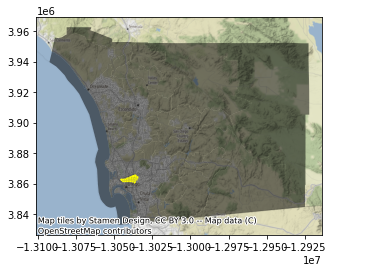

In [41]:
ax = db.plot(alpha=0.5, color="k")
db[db["sub_30"]].plot(ax=ax, color="yellow")
contextily.add_basemap(ax, crs=db.crs);

## Write Out

In [46]:
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   GEOID                628 non-null    object  
 1   geometry             628 non-null    geometry
 2   median_age           628 non-null    float64 
 3   total_pop            628 non-null    float64 
 4   total_pop_white      628 non-null    float64 
 5   tt_work              628 non-null    float64 
 6   hh_total             628 non-null    float64 
 7   hh_female            628 non-null    float64 
 8   total_bachelor       628 non-null    float64 
 9   median_hh_income     628 non-null    float64 
 10  income_gini          628 non-null    float64 
 11  total_housing_units  628 non-null    float64 
 12  total_rented         628 non-null    float64 
 13  median_no_rooms      628 non-null    float64 
 14  median_house_value   628 non-null    float64 
 15  NAME           

- Dataset

In [47]:
! rm -f sandiego_tracts.gpkg
db.to_file("sandiego_tracts.gpkg", driver="GPKG")

- Metadata

In [44]:
! rm -f sandiego_tracts_varnames.json
var_names.to_json("sandiego_tracts_varnames.json")

See: https://www.gis-blog.com/geopackage-vs-shapefile/